In [1]:
import numpy as np
import pandas as pd

customer = pd.read_csv(r"C:\Users\vinee\OneDrive\Desktop\projects\A-B Testing\data\Customer.csv")

In [2]:
customer.dtypes

Unnamed: 0               int64
CustomerID               int64
recency_days             int64
frequency                int64
monetary_funds         float64
avg_order_value        float64
avg_basket_size        float64
total_quantity           int64
unique_products          int64
unique_invoices          int64
tenure_days              int64
most_common_hour         int64
most_common_weekday      int64
last_purchase_month      int64
conversion             float64
dtype: object

In [3]:
customer = customer.drop(columns=["Unnamed: 0"])

np.random.seed(42)
customer['treatment'] = np.random.binomial(1, 0.5, size = len(customer))

In [4]:
customer.head()

,CustomerID,recency_days,frequency,monetary_funds,avg_order_value,avg_basket_size,total_quantity,unique_products,unique_invoices,tenure_days,most_common_hour,most_common_weekday,last_purchase_month,conversion,treatment
0,12346,263,1,77183.60,77183.600000,74215.000000,74215,1,1,0,10,1,1,0.0,0
1,12347,67,5,2790.86,22.506935,12.822581,1590,82,5,237,14,1,8,1.0,1
2,12348,13,4,1797.24,57.975484,75.516129,2341,22,4,282,19,3,9,0.0,1
3,12350,248,1,334.40,19.670588,11.588235,197,17,1,0,16,2,2,0.0,1
4,12352,10,7,2194.31,31.347286,5.842857,409,47,7,224,14,1,9,1.0,0


### lets consider logistic regression models for T-learner.

In [8]:
#X -> all features
#T -> Treatment
#Y -> Conversion

X = customer.drop(columns=["treatment", "conversion"])
T = customer["treatment"]
Y = customer["conversion"]

In [19]:
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

model_treat = LogisticRegression(solver='lbfgs',max_iter=2000)
model_treat.fit(X[T == 1], Y[T == 1])

model_control = LogisticRegression(solver='lbfgs',max_iter=2000)
model_control.fit(X[T == 0], Y[T == 0])


c:\Users\vinee\OneDrive\Desktop\projects\A-B Testing\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\vinee\OneDrive\Desktop\projects\A-B Testing\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    h

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`mul

In [20]:
# uplift scores
pred_treat = model_treat.predict_proba(X)[:, 1]
pred_control = model_control.predict_proba(X)[:, 1]

uplift = pred_treat - pred_control
customer["uplift"] = uplift

In [21]:
customer["uplift_decile"] = pd.qcut(customer["uplift"], 10, labels = False)

customer.groupby("uplift_decile")["conversion"].mean()

uplift_decile
0    0.401617
1    0.442049
2    0.513514
3    0.555256
4    0.559459
5    0.622642
6    0.464865
7    0.458221
8    0.424324
9    0.396226
Name: conversion, dtype: float64

In [22]:
uplift_table = []

for d in range(10):
    group = customer[customer["uplift_decile"] == d]

    treat = group[group["treatment"] == 1]["conversion"].mean()
    control = group[group["treatment"] == 0]["conversion"].mean()

    uplift = treat - control

    uplift_table.append([d, treat, control, uplift])

uplift_df = pd.DataFrame(
    uplift_table,
    columns=["decile", "treat_rate", "control_rate", "uplift"]
)

uplift_df

,decile,treat_rate,control_rate,uplift
0,0,0.365079,0.439560,-0.074481
1,1,0.427083,0.458101,-0.031017
2,2,0.548571,0.482051,0.066520
3,3,0.522727,0.584615,-0.061888
4,4,0.578947,0.538889,0.040058
5,5,0.610526,0.635359,-0.024833
6,6,0.464286,0.465517,-0.001232
7,7,0.471503,0.443820,0.027682
8,8,0.441341,0.408377,0.032964
9,9,0.440860,0.351351,0.089509


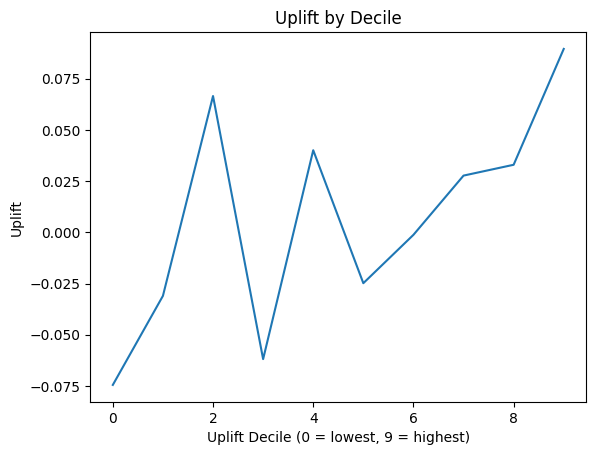

In [23]:
import matplotlib.pyplot as plt

plt.plot(uplift_df["decile"], uplift_df["uplift"])
plt.xlabel("Uplift Decile (0 = lowest, 9 = highest)")
plt.ylabel("Uplift")
plt.title("Uplift by Decile")
plt.show()

In [24]:
df_q = customer.sort_values("uplift", ascending=False).reset_index(drop = True)

In [25]:
p = customer["treatment"].mean()

df_q["gain"] = df_q.apply(
    lambda row: row["conversion"] / p if row["treatment"] == 1 else -row["conversion"] / (1-p),
    axis = 1
)

In [26]:
df_q["cumulative_gain"] = df_q["gain"].cumsum()

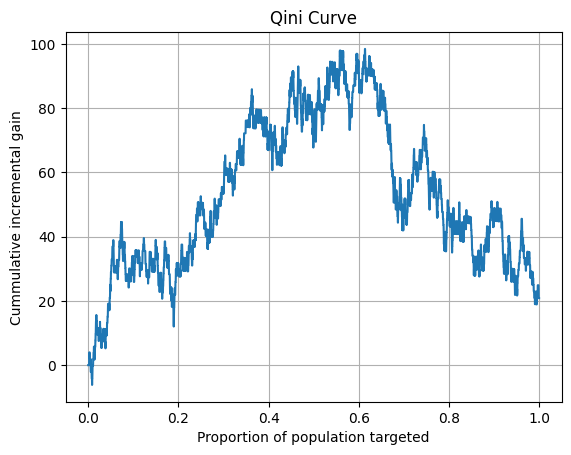

In [27]:
plt.plot(df_q.index / len(df_q), df_q["cumulative_gain"])
plt.xlabel("Proportion of population targeted")
plt.ylabel("Cummulative incremental gain")
plt.title("Qini Curve")
plt.grid(True)
plt.show()